In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid') # sns에 흰색 그리드 유지
import missingno # 결측치 시각화

# KFold (교차 검증을 사용하기 위해)
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# 학습 데이터와 검증 데이터로 나누는 함수
from sklearn.model_selection import train_test_split

# 데이터 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 평가 함수
from sklearn.metrics import accuracy_score

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import  XGBRegressor

# 머신러닝 알고리즘 - 군집
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift

# 머신러닝 알고리즘 - 차원축소
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 딥러닝 알고리즘 
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

# 다중분류를 위한 원핫 인코더
from keras.utils import to_categorical

# 학습 자동 중단
from keras.callbacks import EarlyStopping

# 모델 저장
from keras.callbacks import ModelCheckpoint

# 저장된 딥러닝 모델 불러오기
from keras.models import load_model

# 저장
import pickle

# 시간 모듈
import time

# 그래프 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'   # 윈도우용
plt.rcParams['font.family'] = 'AppleGothic'   # 맥용
plt.rcParams['font.size'] = 16                  # 폰트 크기
plt.rcParams['figure.figsize'] = 10,8          # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False     # - 기호 깨짐 방지


# 경고 메시지가 안나오게 하기
import warnings
warnings.filterwarnings('ignore')

### 데이터 불러오기

In [2]:
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')

### Missingno를 활용한 결측치 확인

In [3]:
# 결측치 확인
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

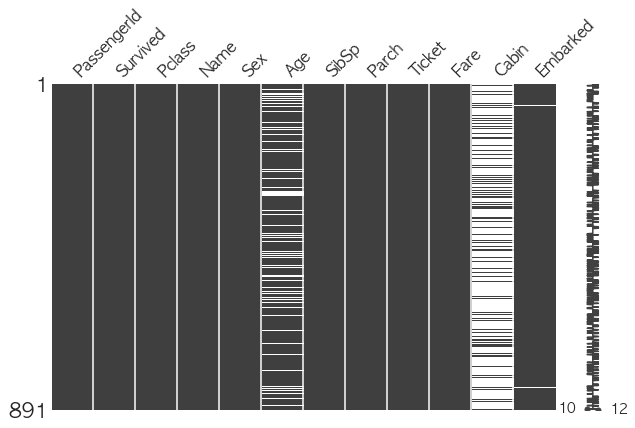

In [4]:
missingno.matrix(train_df, figsize=(10,6))
plt.show()

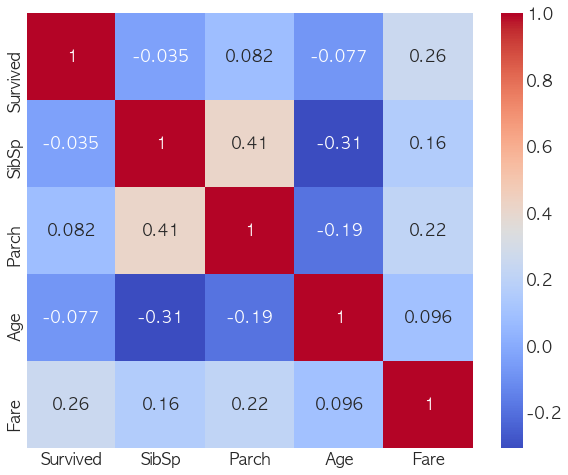

In [5]:
# 수치화 되어 있는 데이터 간의 상관관계를 확인한다.
a1 = train_df[['Survived','SibSp','Parch','Age','Fare']]
# a1.head()

sns.heatmap(a1.corr(), annot=True, cmap='coolwarm')
plt.show()

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### 전체 생존자 숫자 확인하기

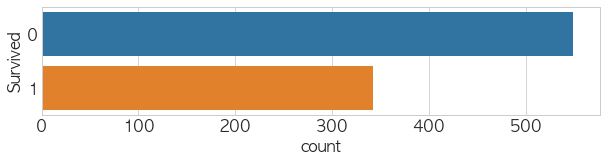

In [7]:
# countplot : 지정된 컬럼안에 저장되어 있는 값들의 개수를 보여주는 그래프
plt.figure(figsize=(10,2))
sns.countplot(y='Survived', data=train_df)
plt.show()

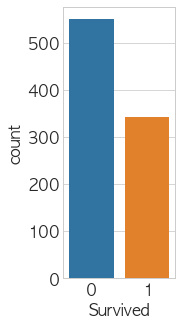

In [8]:
# countplot : 지정된 컬럼안에 저장되어 있는 값들의 개수를 보여주는 그래프
plt.figure(figsize=(2,5))
sns.countplot(x='Survived', data=train_df)
plt.show()

### 서브 플롯

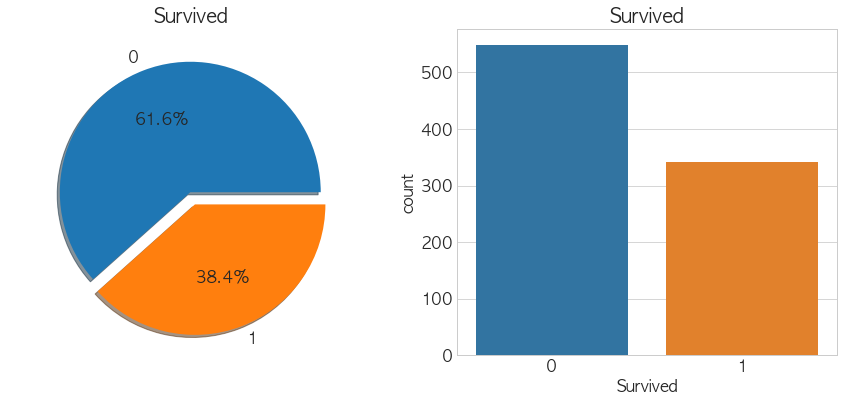

In [9]:
# 몇개의 그래프를 그릴것인지 결정
# 1 : 1줄
# 2 : 2칸
f, ax = plt.subplots(1,2,figsize=(15,6))

# 파이 그래프
a1 = train_df['Survived'].value_counts()
a1.plot.pie(ax = ax[0],explode=[0,0.1], autopct='%1.1f%%', shadow=True)
ax[0].set_title('Survived')
ax[0].set_ylabel(' ')

# 카운터 플롯
sns.countplot('Survived', data=train_df, ax=ax[1])
ax[1].set_title('Survived')

plt.show()

### Pclass당 남녀 생존 확률을 팩토 플롯으로 확인

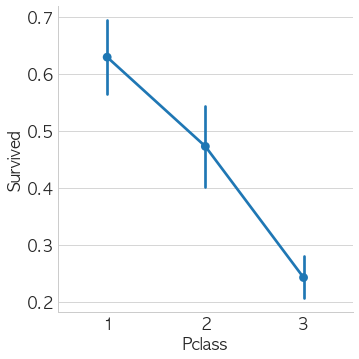

In [10]:
# Pclass별 생존 비율
sns.factorplot('Pclass', 'Survived', data=train_df)
plt.show()

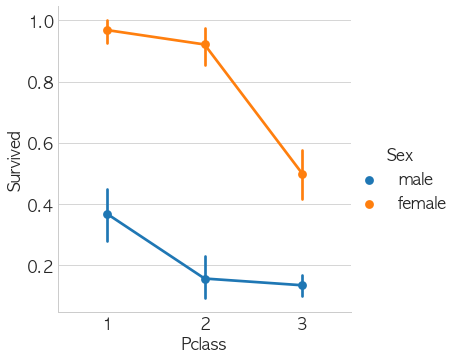

In [11]:
# Pclass당 남녀 생존 비율
sns.factorplot('Pclass', 'Survived', hue='Sex', data=train_df)
plt.show()

### 크로스탭을 활용하여 Pclass별 생존자 숫자보기

In [12]:
# margins:총합까지 출력
# .style.background_gradient(cmap='summer_r') : 색상구분
pd.crosstab(train_df['Pclass'], train_df['Survived'], margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


### 막대 그래프

In [13]:
a1 = train_df[['Pclass', 'Survived']].groupby('Pclass').mean()

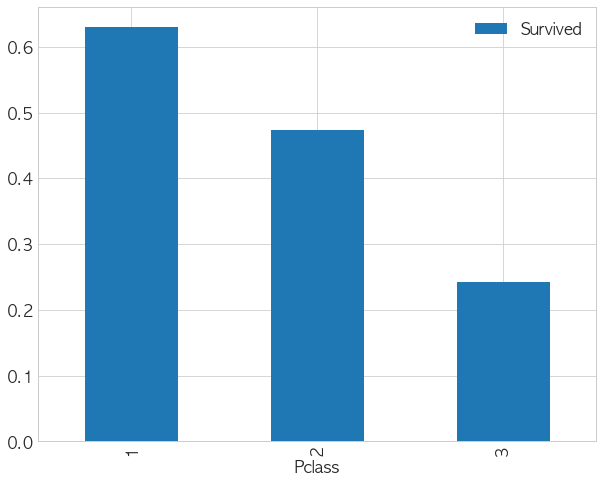

In [14]:
a1.plot.bar()
plt.show()

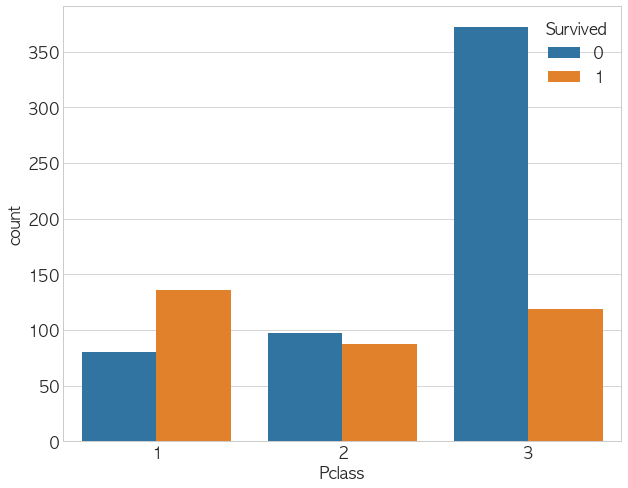

In [15]:
sns.countplot('Pclass',hue='Survived',data=train_df)
plt.show()

### Densitiy Plot

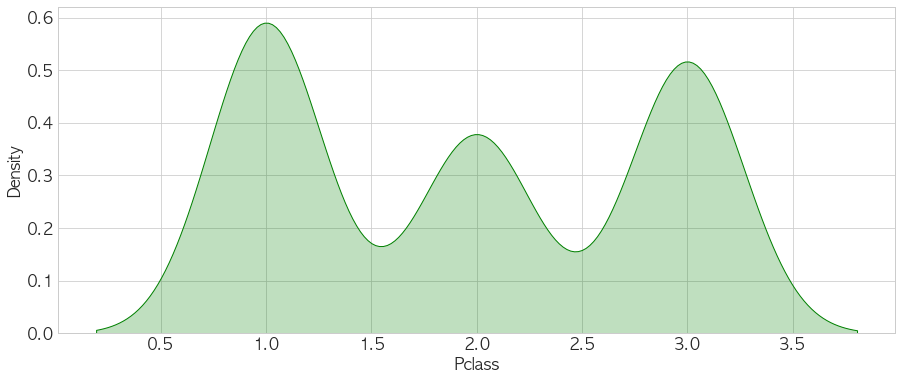

In [16]:
# 그래프의 크기
plt.figure(figsize=(15,6))

# # 사망자
# sns.kdeplot(train_df.Pclass[train_df.Survived == 0], color='gray', shade=True, label='not survived')

# 생존자
sns.kdeplot(train_df.Pclass[train_df.Survived == 1], color='g', shade=True, label='survived')

# plt.title('승객 등급간 사망 생존 비율', fontsize=20)
# plt.ylabel('생존 승객 비율')
# plt.xlabel('승객 등급')

# plt.xticks(sorted(train_df.Pclass.unique()), ['1등석', '2등석','3등석'])
# plt.legend()
plt.show()

### violin plot을 활용하여 Pclass별 Fare 보기

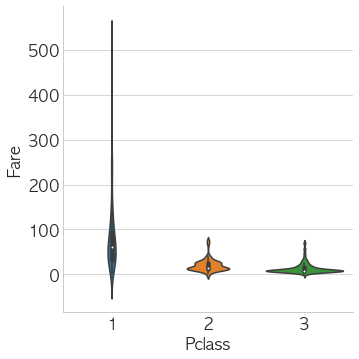

In [17]:
sns.catplot(x='Pclass', y='Fare', kind='violin', data=train_df)
plt.show()